In [76]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_extract import Scale_spectra
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


In [77]:
galDB = pd.read_pickle('../dataframes/galaxy_database.pkl')
BFs = pd.read_pickle('../dataframes/BF_fit_all.pkl')
lwa = np.load('../data/light_weight_scaling_3.npy')
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [78]:
data_path = '../data/'
model_path = hpath + 'fsps_models_for_fit/fsps_spec/'
chi_path = '../chidat/'
spec_path = '../spec_files/'
beam_path = '../beams/'
template_path = '../templates/'
out_path = '../data/posteriors/'
phot_path = '../phot/'

def L_nu_per_M(l_aa, lam, z, Av, m_star):
    c = 3E18 # speed of light in angstrom
    lam_0 = lam / (1 + z) # restframe wavelenth in angstrom
    dust = 10**(-0.4*Av)
    return ((lam_0**2)/(c * m_star)) * l_aa * dust * 3.839E33

def F_nu_per_M(l_aa, lam, z, Av, m_star):
    conv = 3.086E24 # conversion of Mpc to cm
    D_l = cosmo.luminosity_distance(z).value # in Mpc
    return (1 + z) * L_nu_per_M(l_aa, lam, z, Av, m_star)  / (4 * np.pi * (D_l*conv)**2)

def F_lam_per_M(l_aa, lam, z, Av, m_star):
    c = 3E18 # speed of light in angstrom
    return (c / lam**2) * F_nu_per_M(l_aa, lam, z, Av, m_star)

def Get_mass(gwv, gfl, ger, Z, t, z, Av):
    sp = fsps.StellarPopulation(imf_type=1, tpagb_norm_type=0, zcontinuous=1, logzsol=np.log10(Z / 0.019), sfh=0)
    wave,flux=np.array(sp.get_spectrum(tage=t,peraa=True))
    
    fl_m = F_lam_per_M(flux, wave * (1 + z), z, Av, sp.stellar_mass)
    
    IDX = [U for U in range(len(gwv)) if 8000 < gwv[U] < 11300]
    return np.log10(Scale_model(gfl[IDX],ger[IDX],interp1d(wv,fl_m)(gwv[IDX])))

def Calzetti_low(Av,lam):
    lam = lam * 1E-4
    Rv=4.05
    k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
    cal = 10**(-0.4*k*Av/Rv)
    return cal

def Calzetti_hi(Av,lam):
    lam = lam * 1E-4
    Rv=4.05
    k = 2.659*(-1.857 +1.04/(lam)) + Rv
    cal = 10**(-0.4*k*Av/Rv)    
    
    return cal

def Calzetti(Av,lam):
    dust = Calzetti_low(Av,lam)
    dust2 = Calzetti_hi(Av,lam)
    
    for ii in range(len(dust)):
        if lam[ii] > 6300:
            dust[ii]=dust2[ii] 
    
    return dust

class Gen_sim(object):
    def __init__(self, field, galaxy_id, specz, g102_beam, g141_beam,
                 model_wv, model_fl, mass, stellar_mass,
                 g102_lims = [7900, 11300], g141_lims = [11100, 16000],
                tmp_err = False, phot_errterm = 0, offset = True,
                offset_limit = 0.1):
        self.field = field
        self.galaxy_id = galaxy_id
        self.specz = specz
        self.c = 3E18          # speed of light angstrom s^-1
        self.g102_lims = g102_lims
        self.g141_lims = g141_lims
        self.offset = offset
        """
        B - prefix refers to g102
        R - prefix refers to g141
        P - prefix refers to photometry
        
        field - GND/GSD/UDS
        galaxy_id - ID number from 3D-HST
        specz - z_grism
        g102_lims - window for g102
        g141_lims - window for g141
        tmp_err - (flag) whether or not we apply a template error function (not available)
        """
        self.Bwv, self.Bflx, self.Berr, self.Bflt = np.load(spec_path + '{0}_{1}_g102.npy'.format(field, galaxy_id))
        self.Rwv, self.Rflx, self.Rerr, self.Rflt = np.load(spec_path + '{0}_{1}_g141.npy'.format(field, galaxy_id))
        self.Bmask = np.load(spec_path + 'spec_mask/{0}_{1}_g102_mask.npy'.format(field, galaxy_id))
        self.Rmask = np.load(spec_path + 'spec_mask/{0}_{1}_g141_mask.npy'.format(field, galaxy_id))
        
        self.Bwv = self.Bwv[self.Bmask]
        self.Bflt = self.Bflt[self.Bmask]
        self.Bflx = self.Bflx[self.Bmask]
        self.Berr = self.Berr[self.Bmask] 
        
        self.Rwv = self.Rwv[self.Rmask]
        self.Rflt = self.Rflt[self.Rmask]
        self.Rflx = self.Rflx[self.Rmask]
        self.Rerr = self.Rerr[self.Rmask] 
        
        self.Pwv, self.Pflx, self.Perr, self.Pnum = np.load(phot_path + '{0}_{1}_phot.npy'.format(field, galaxy_id))
        self.Pwv_rf = self.Pwv / (1 + self.specz)
                
        self.IDB = [U for U in range(len(self.Bwv)) if g102_lims[0] <= self.Bwv[U] <= g102_lims[-1] and self.Bflx[U]**2 > 0]
        self.IDR = [U for U in range(len(self.Rwv)) if g141_lims[0] <= self.Rwv[U] <= g141_lims[-1] and self.Rflx[U]**2 > 0]

        self.Bwv = self.Bwv[self.IDB]
        self.Bwv_rf = self.Bwv / (1 + specz)
        self.Bflt = self.Bflt[self.IDB]
        self.Bflx = self.Bflx[self.IDB] 
        self.Berr = self.Berr[self.IDB] 
        
        self.Rwv = self.Rwv[self.IDR]
        self.Rwv_rf = self.Rwv / (1 + specz)
        self.Rflt = self.Rflt[self.IDR]
        self.Rflx = self.Rflx[self.IDR]
        self.Rerr = self.Rerr[self.IDR] 

        self.model_photDF = pd.read_pickle(phot_path + 'model_photometry_list.pkl')
        
        self.IDP = []
        for i in range(len(self.Pnum)):
            for ii in range(len(self.model_photDF)):
                if self.Pnum[i] == self.model_photDF.tmp_num[self.model_photDF.index[ii]]:
                    self.IDP.append(ii)
        
        ### set beams
        self.Bbeam = model.BeamCutout(fits_file = g102_beam)
        self.Rbeam = model.BeamCutout(fits_file = g141_beam)
        
        
        ### Set transmission curve
        model_wave, model_flux = np.load(model_path + 'm0.019_a2.0_dt0_spec.npy')
        Bw,Bfl = self.Sim_spec_indv(self.Bbeam, model_wave, np.ones(len(model_wave)))
        Rw,Rfl = self.Sim_spec_indv(self.Rbeam, model_wave, np.ones(len(model_wave)))
        self.Btrans = interp1d(Bw,Bfl)(self.Bwv)       
        self.Rtrans = interp1d(Rw,Rfl)(self.Rwv) 
        
        ### Define precalculated terms for photometry
        self.sens_wv, self.trans = np.load(template_path + 'master_tmp.npy')
        self.b = np.load(template_path + 'bottom_precalc.npy')
        self.dnu = np.load(template_path + 'dnu_precalc.npy')
        self.adj = np.load(template_path + 'adj_precalc.npy')
        self.mdleffwv = np.load(template_path + 'effwv_precalc.npy') 
        
        ### set sim
        fl_sol = F_lam_per_M(model_fl * (1 + specz), model_wv, specz, 0, stellar_mass)
        
        f_lam = fl_sol * 10**(mass)
        
        self.Bsnr = np.abs(self.Bflx / self.Berr)
        self.Rsnr = np.abs(self.Rflx / self.Rerr)
        self.Psnr = np.abs(self.Pflx / np.sqrt(self.Perr**2 + (phot_errterm * self.Pflx)**2))

        SPwv, self.SPfl = self.Sim_phot_mult(model_wave*(1 + self.specz), f_lam)
        self.SPer = self.SPfl / self.Psnr

        [Bmw, Bmf], [Rmw, Rmf] = self.Sim_spec_mult(model_wave*(1 + self.specz), f_lam)
        iBmf = interp1d(Bmw,Bmf)(self.Bwv)       
        iRmf = interp1d(Rmw,Rmf)(self.Rwv)     

        SBfl = iBmf / self.Btrans
        SRfl = iRmf / self.Rtrans

        self.SBer = SBfl / self.Bsnr
        self.SRer = SRfl / self.Rsnr

        self.SPflx = self.SPfl + np.random.normal(0, np.abs(self.SPer))
        self.SBflx = SBfl + np.random.normal(0, np.abs(self.SBer))
        self.SRflx = SRfl + np.random.normal(0, np.abs(self.SRer))

        offset_range = np.arange(- offset_limit,offset_limit + 0.001,0.001)
        self.offset_B = np.random.choice(offset_range,1) + 1
        self.offset_R = np.random.choice(offset_range,1) + 1  

        self.SBflx *= self.offset_B ; self.SBer *= self.offset_B
        self.SRflx *= self.offset_R ; self.SRer *= self.offset_R
            
        if tmp_err:
            WV,TEF = np.load(template_path + 'template_error_updt.npy')
            iTEF = interp1d(WV,TEF)(self.Bwv_rf)
            self.SBer = np.sqrt(self.SBer**2 + (iTEF*self.SBflx)**2)

            iTEF = interp1d(WV,TEF)(self.Rwv_rf)
            self.SRer = np.sqrt(self.SRer**2 + (iTEF*self.SRflx)**2)
            
            iTEF = interp1d(WV,TEF)(self.Pwv_rf)
            self.SPer = np.sqrt(self.SPer**2 + (iTEF * self.SPflx)**2+ (phot_errterm * self.SPflx)**2)
        else:
            self.SPer = np.sqrt(self.SPer**2 + (phot_errterm * self.SPflx)**2)  
    
    def Sim_spec_indv(self, BEAM, model_wave, model_flux):
        ### creates a model using an individual beam
        BEAM.beam.compute_model(spectrum_1d=[model_wave, model_flux])
        w, f, e = BEAM.beam.optimal_extract(BEAM.beam.model, bin=0)
        return w, f
        
    def Sim_spec_mult(self, model_wave, model_flux):
        ### creates a model for g102 and g141 using individual beams
        return self.Sim_spec_indv(self.Bbeam, model_wave, model_flux), \
                self.Sim_spec_indv(self.Rbeam, model_wave, model_flux)

    def Sim_spec(self, metal, age, tau, model_redshift = 0, Av = 0, multi_component = False,
                point_scale=1):
        if model_redshift ==0:
            model_redshift = self.specz

        model_wave, model_flux = np.load(model_path + 'm{0}_a{1}_dt{2}_spec.npy'.format(
            metal, age, tau))

        [Bmw, Bmf], [Rmw, Rmf] = self.Sim_spec_mult(model_wave * (1 + model_redshift), 
                                                                        model_flux * Calzetti(Av,model_wave))
        iBmf = interp1d(Bmw,Bmf)(self.Bwv)       
        iRmf = interp1d(Rmw,Rmf)(self.Rwv)     
        
        self.Bmfl = iBmf / self.Btrans
        self.Rmfl = iRmf / self.Rtrans
            
        self.Bmfl *= self.PC
        self.Rmfl *= self.PC
        
        if self.offset:
            Bscale = Scale_model(self.SBflx, self.SBer, self.Bmfl)
            Rscale = Scale_model(self.SRflx, self.SRer, self.Rmfl)

            self.SBflx = self.SBflx / Bscale ; self.SBer = self.SBer / Bscale 
            self.SRflx = self.SRflx / Rscale ; self.SRer = self.SRer / Rscale 
       
    def Sim_phot_mult(self, model_wave, model_flux):
        
        imfl =interp1d(self.c / model_wave, (self.c/(self.c / model_wave)**2) * model_flux)

        mphot = (np.trapz(imfl(self.c /(self.sens_wv[self.IDP])).reshape([len(self.IDP),len(self.sens_wv[0])]) \
                          * self.b[self.IDP],self.dnu[self.IDP])/np.trapz(self.b[self.IDP],
                                                                          self.dnu[self.IDP])) * self.adj[self.IDP]
        
        return np.array([self.mdleffwv[self.IDP],mphot])

    def Sim_phot(self, metal, age, tau, model_redshift = 0, Av = 0):
        if model_redshift ==0:
            model_redshift = self.specz

        model_wave, model_flux = np.load(model_path + 'm{0}_a{1}_dt{2}_spec.npy'.format(
            metal, age, tau))
        
        self.Pmwv, self.Pmfl = self.Sim_phot_mult(model_wave * (1 + model_redshift), 
                                                  model_flux * Calzetti(Av,model_wave))
        self.PC =  Scale_model(self.SPflx, self.SPer, self.Pmfl)  
        self.Pmfl = self.Pmfl * self.PC
        
    def Sim_all(self, metal, age, tau, model_redshift = 0, Av = 0):
        self.Sim_phot(metal, age, tau, model_redshift, Av)
        self.Sim_spec(metal, age, tau, model_redshift, Av)
        
    def Scale_flux(self, bfZ, bft, bftau, bfz, bfd):
        model_wave, model_flux = np.load(model_path + 'm{0}_a{1}_dt{2}_spec.npy'.format(bfZ, bft, bftau))
        
        US_model_flux = F_lam_per_M(model_flux * Calzetti(bfd,model_wave), model_wave * (1 + bfz), bfz, 0, 1)

        US_pwv, US_pfl = self.Sim_phot_mult(model_wave * (1 + bfz), US_model_flux)
        
        self.mass = Scale_model(self.SPflx, self.SPer, US_pfl)
        
        self.lmass = np.log10(self.mass)
        
        self.model_wave = model_wave
        self.S_model_flux = US_model_flux * self.mass
          
        Bw,Bf = self.Sim_spec_indv(self.Bbeam, self.model_wave * (1 + bfz), self.S_model_flux)
        Rw,Rf = self.Sim_spec_indv(self.Rbeam, self.model_wave * (1 + bfz), self.S_model_flux)
        
        iBmf = interp1d(Bw,Bf)(self.Bwv)       
        iRmf = interp1d(Rw,Rf)(self.Rwv)  
  
        Bmfl = iBmf / self.Btrans
        Rmfl = iRmf /self.Rtrans

        self.Bscale = Scale_model(self.SBflx, self.SBer, Bmfl)
        self.Rscale = Scale_model(self.SRflx, self.SRer, Rmfl)
        
        self.SBflx = self.SBflx / self.Bscale ; self.SBer = self.SBer / self.Bscale 
        self.SRflx = self.SRflx / self.Rscale ; self.SRer = self.SRer / self.Rscale 
        
        self.offset = False


In [6]:
idx = 22

sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.019/0.019), sfh = 4, tau = 0.1)
wave, flux = sp.get_spectrum(tage = 2.3, peraa = True)


In [16]:
sim1 = Gen_sim(galDB.field[idx], galDB.ids[idx], galDB.z_grism[idx], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0],wave,flux,11,sp.stellar_mass,
              g102_lims=[8500,11300],tmp_err=True, phot_errterm=0.03, offset=True, offset_limit=0.5 )

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


57.71202157565455
125.40410951900338
1298.0391377273827
1782.3915494673527
6964.647823877541
1298.0391377273827


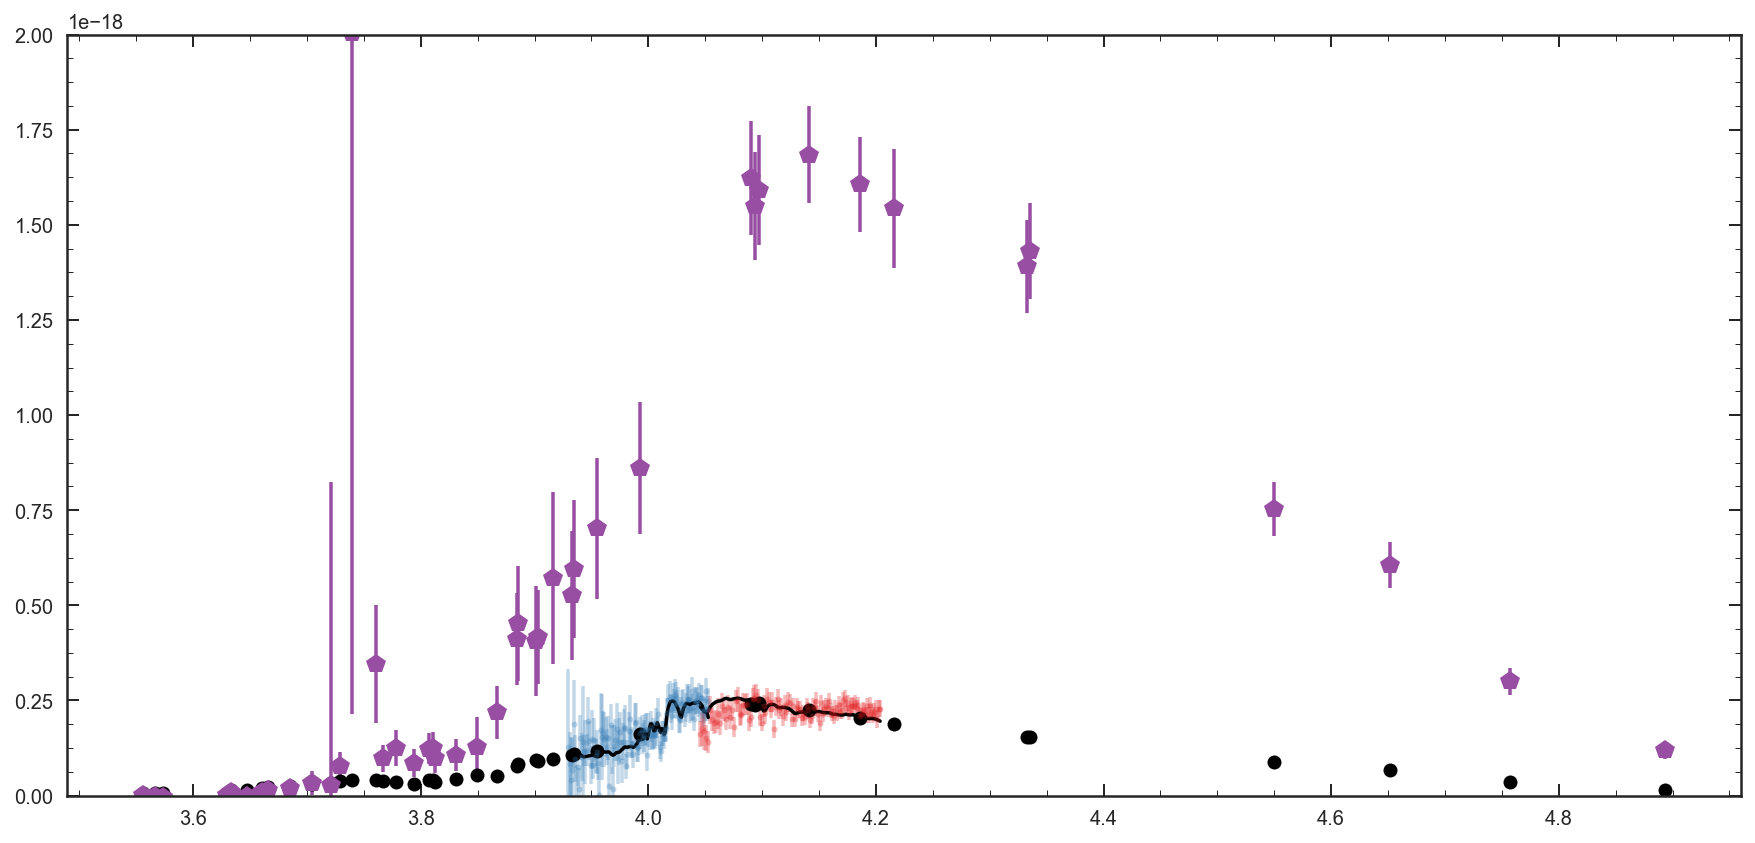

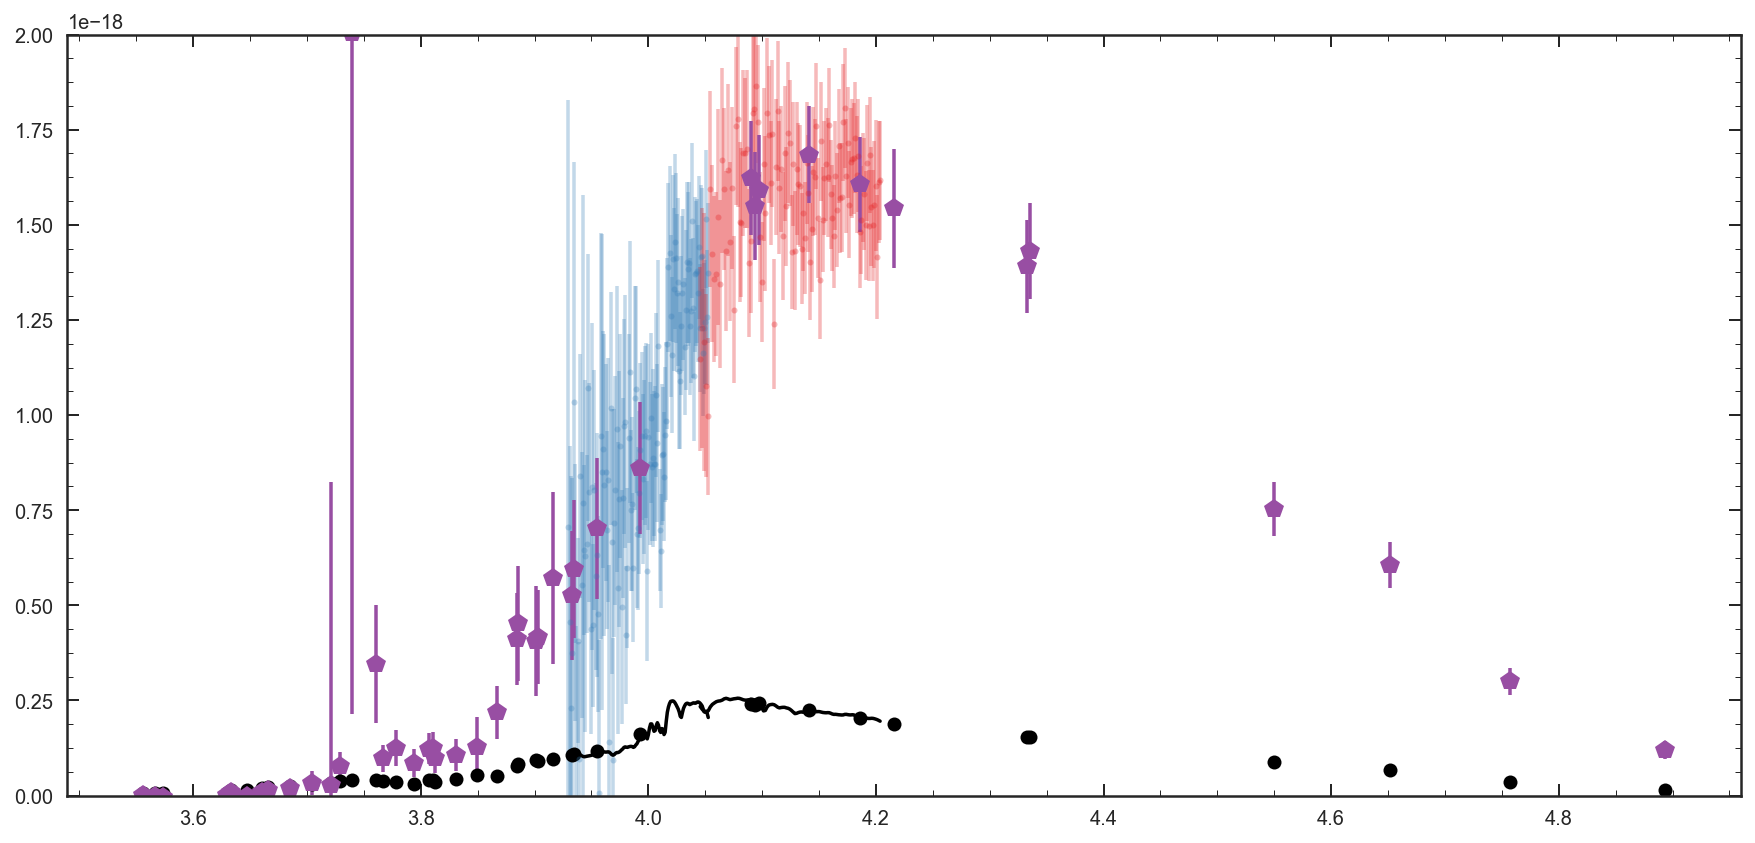

In [18]:
sim1.Sim_all(0.019,1.2,8.0)

plt.figure(figsize=[15,7])

plt.errorbar(np.log10(sim1.Bwv), sim1.SBflx, sim1.SBer,
                             linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.plot(np.log10(sim1.Bwv), sim1.Bmfl,'k')
plt.errorbar(np.log10(sim1.Rwv), sim1.SRflx, sim1.SRer,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)
plt.plot(np.log10(sim1.Rwv), sim1.Rmfl,'k')
plt.errorbar(np.log10(sim1.Pwv), sim1.SPflx, sim1.SPer,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')
plt.plot(np.log10(sim1.Pwv), sim1.Pmfl,'ko')
plt.ylim(0,0.2E-17)

print(Chi_Squared(sim1.SBflx, sim1.Bmfl, sim1.SBer))
print(Chi_Squared(sim1.SRflx, sim1.Rmfl, sim1.SRer))
print(Chi_Squared(sim1.SPflx, sim1.Pmfl, sim1.SPer))

sim1.Scale_flux(0.019, 2.3, 8.0, 1.608, 0)
sim1.Sim_all(0.019,1.2,8.0)

plt.figure(figsize=[15,7])

plt.errorbar(np.log10(sim1.Bwv), sim1.SBflx, sim1.SBer,
                             linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.plot(np.log10(sim1.Bwv), sim1.Bmfl,'k')
plt.errorbar(np.log10(sim1.Rwv), sim1.SRflx, sim1.SRer,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)
plt.plot(np.log10(sim1.Rwv), sim1.Rmfl,'k')
plt.errorbar(np.log10(sim1.Pwv), sim1.SPflx, sim1.SPer,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')
plt.plot(np.log10(sim1.Pwv), sim1.Pmfl,'ko')
plt.ylim(0,0.2E-17)

print(Chi_Squared(sim1.SBflx, sim1.Bmfl, sim1.SBer))
print(Chi_Squared(sim1.SRflx, sim1.Rmfl, sim1.SRer))
print(Chi_Squared(sim1.SPflx, sim1.Pmfl, sim1.SPer))

In [266]:
sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.0186/0.019), sfh = 4, tau = 0.095)
wave, flux = sp.get_spectrum(tage = 2.254, peraa = True)

sim1 = Gen_sim(galDB.field[idx], galDB.ids[idx], galDB.z_grism[idx], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0],wave,flux,11,sp.stellar_mass,
              g102_lims=[8500,11300],tmp_err=True, phot_errterm=0.03, offset=True, offset_limit=0.5 )

In [330]:
x = age

Bchi1 = np.zeros(len(x)) ; Rchi1 = np.zeros(len(x)) ; Pchi1 = np.zeros(len(x))
Bchi2 = np.zeros(len(x)) ; Rchi2 = np.zeros(len(x)) ; Pchi2 = np.zeros(len(x))
PC1 = np.zeros(len(x))

for i in range(len(x)):
    sim1.Sim_all(0.019,x[i],8.0)    
    
    PC1[i] = sim1.PC
    Bchi1[i] = Chi_Squared(sim1.SBflx, sim1.Bmfl, sim1.SBer)
    Rchi1[i] = Chi_Squared(sim1.SRflx, sim1.Rmfl, sim1.SRer)
    Pchi1[i] = Chi_Squared(sim1.SPflx, sim1.Pmfl, sim1.SPer)

Tchi1 = Bchi1 + Rchi1 +Pchi1
    
sim1.Scale_flux(0.019, x[Tchi1 == min(Tchi1)][0], 8.0, 1.608, 0)
    
for i in range(len(x)):
    sim1.Sim_all(0.019,x[i],8.0)    

    Bchi2[i] = Chi_Squared(sim1.SBflx, sim1.Bmfl, sim1.SBer)
    Rchi2[i] = Chi_Squared(sim1.SRflx, sim1.Rmfl, sim1.SRer)
    Pchi2[i] = Chi_Squared(sim1.SPflx, sim1.Pmfl, sim1.SPer)
    
Tchi2 = Bchi2 + Rchi2 +Pchi2


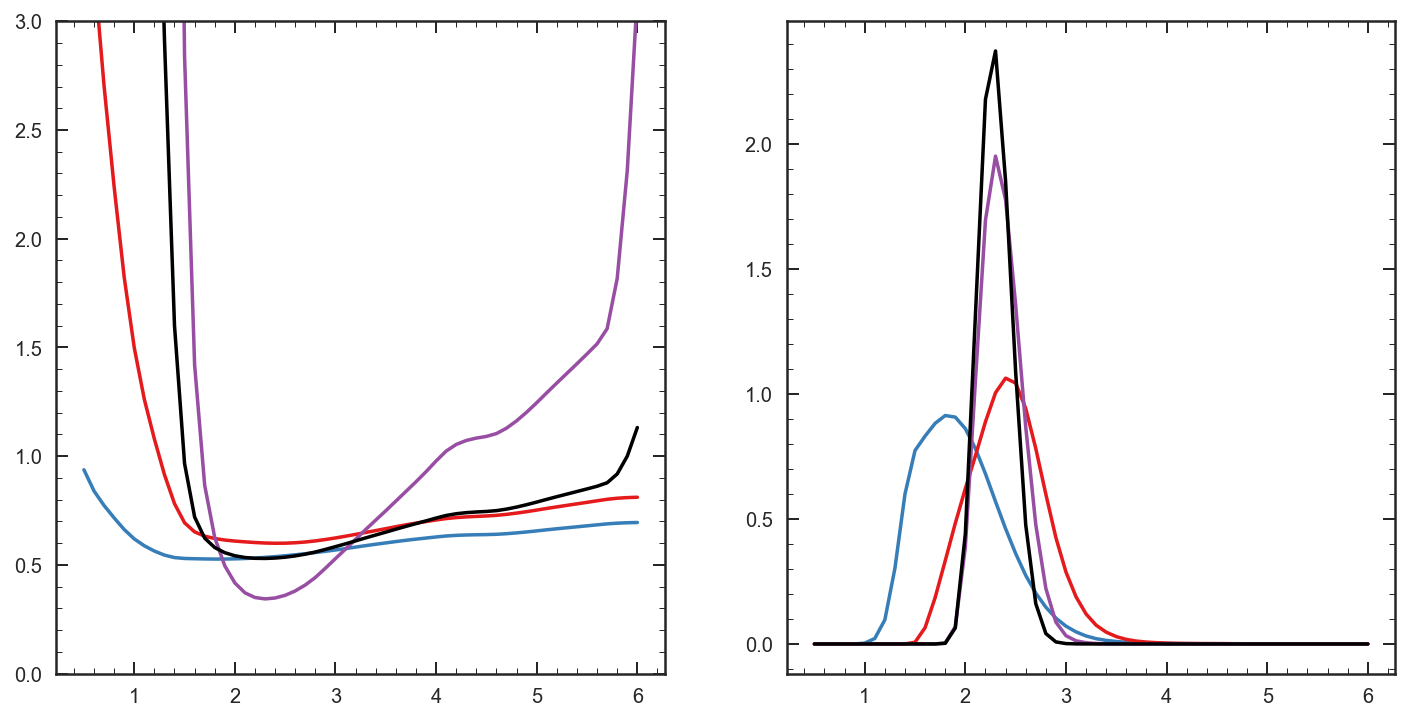

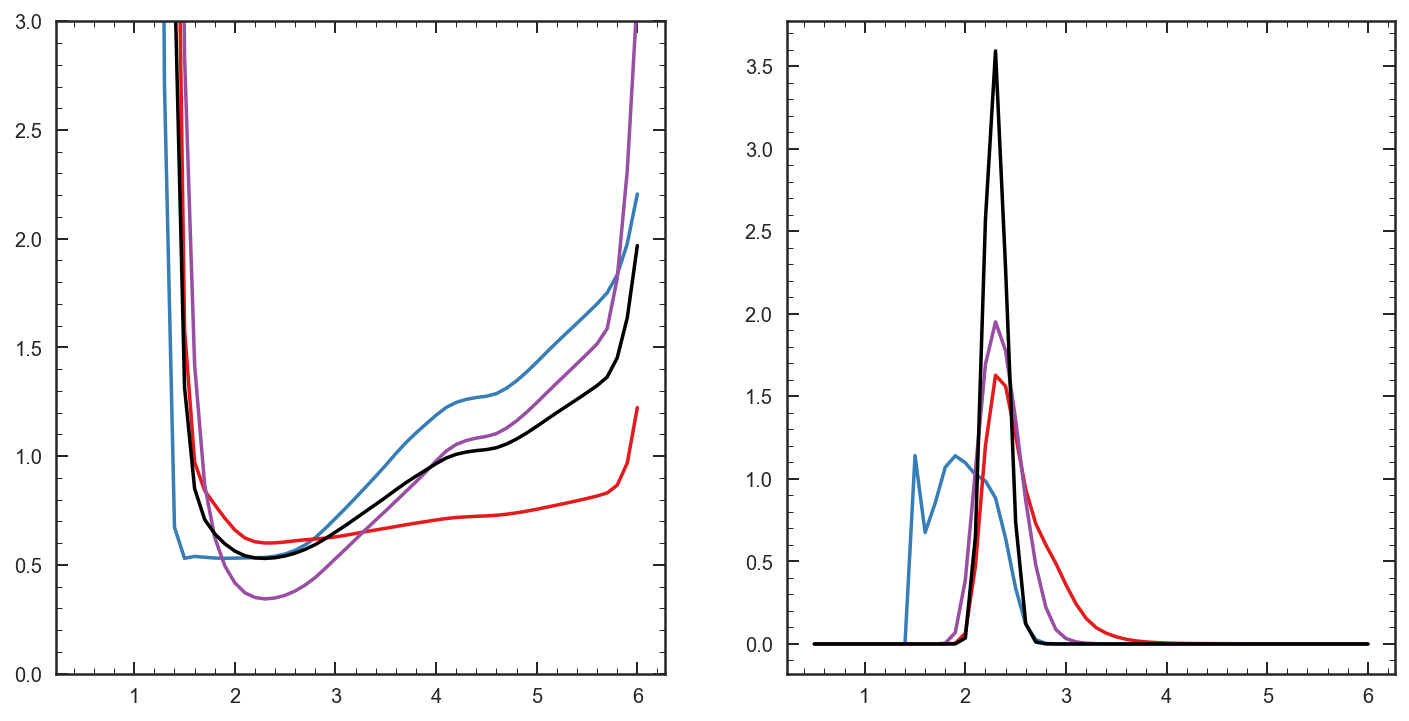

In [338]:
gs = GridSpec(1,2)


plt.figure(figsize=[12,6])
plt.subplot(gs[0])
plt.plot(x,Bchi1/len(sim1.Bflx),color='#377eb8')
plt.plot(x,Rchi1/len(sim1.Rflx),color='#e41a1c')
plt.plot(x,Pchi1/len(sim1.Pflx), color='#984ea3')
plt.plot(x,Tchi1/(len(sim1.Bflx) + len(sim1.Rflx) + len(sim1.Pflx)),'k')
plt.ylim(0,3)
plt.subplot(gs[1])
plt.plot(x,P(Bchi1,x),color='#377eb8')
plt.plot(x,P(Rchi1,x),color='#e41a1c')
plt.plot(x,P(Pchi1,x), color='#984ea3')
plt.plot(x,P(Tchi1,x),'k')

plt.figure(figsize=[12,6])
plt.subplot(gs[0])
plt.plot(x,Bchi2/len(sim1.Bflx),color='#377eb8')
plt.plot(x,Rchi2/len(sim1.Rflx),color='#e41a1c')
plt.plot(x,Pchi2/len(sim1.Pflx), color='#984ea3')
plt.plot(x,Tchi2/(len(sim1.Bflx) + len(sim1.Rflx) + len(sim1.Pflx)),'k')
plt.ylim(0,3)

plt.subplot(gs[1])
plt.plot(x,P(Bchi2,x),color='#377eb8')
plt.plot(x,P(Rchi2,x),color='#e41a1c')
plt.plot(x,P(Pchi2,x), color='#984ea3')
plt.plot(x,P(Tchi2,x),'k')

In [271]:
Median_w_Error_cont(P(Tchi1,x),x)

(2.2122122122122123, 0.13213213213213226, 0.14314314314314291)

In [272]:
Median_w_Error_cont(P(Tchi2,x),x)

(2.206706706706707, 0.09909909909909942, 0.11011011011011007)

In [41]:
def P(F,x):
    F = np.array(F).astype(np.float128)
    return np.exp(-np.array(F) / 2) / np.trapz(np.exp(-np.array(F) / 2),x)

(3, 5)

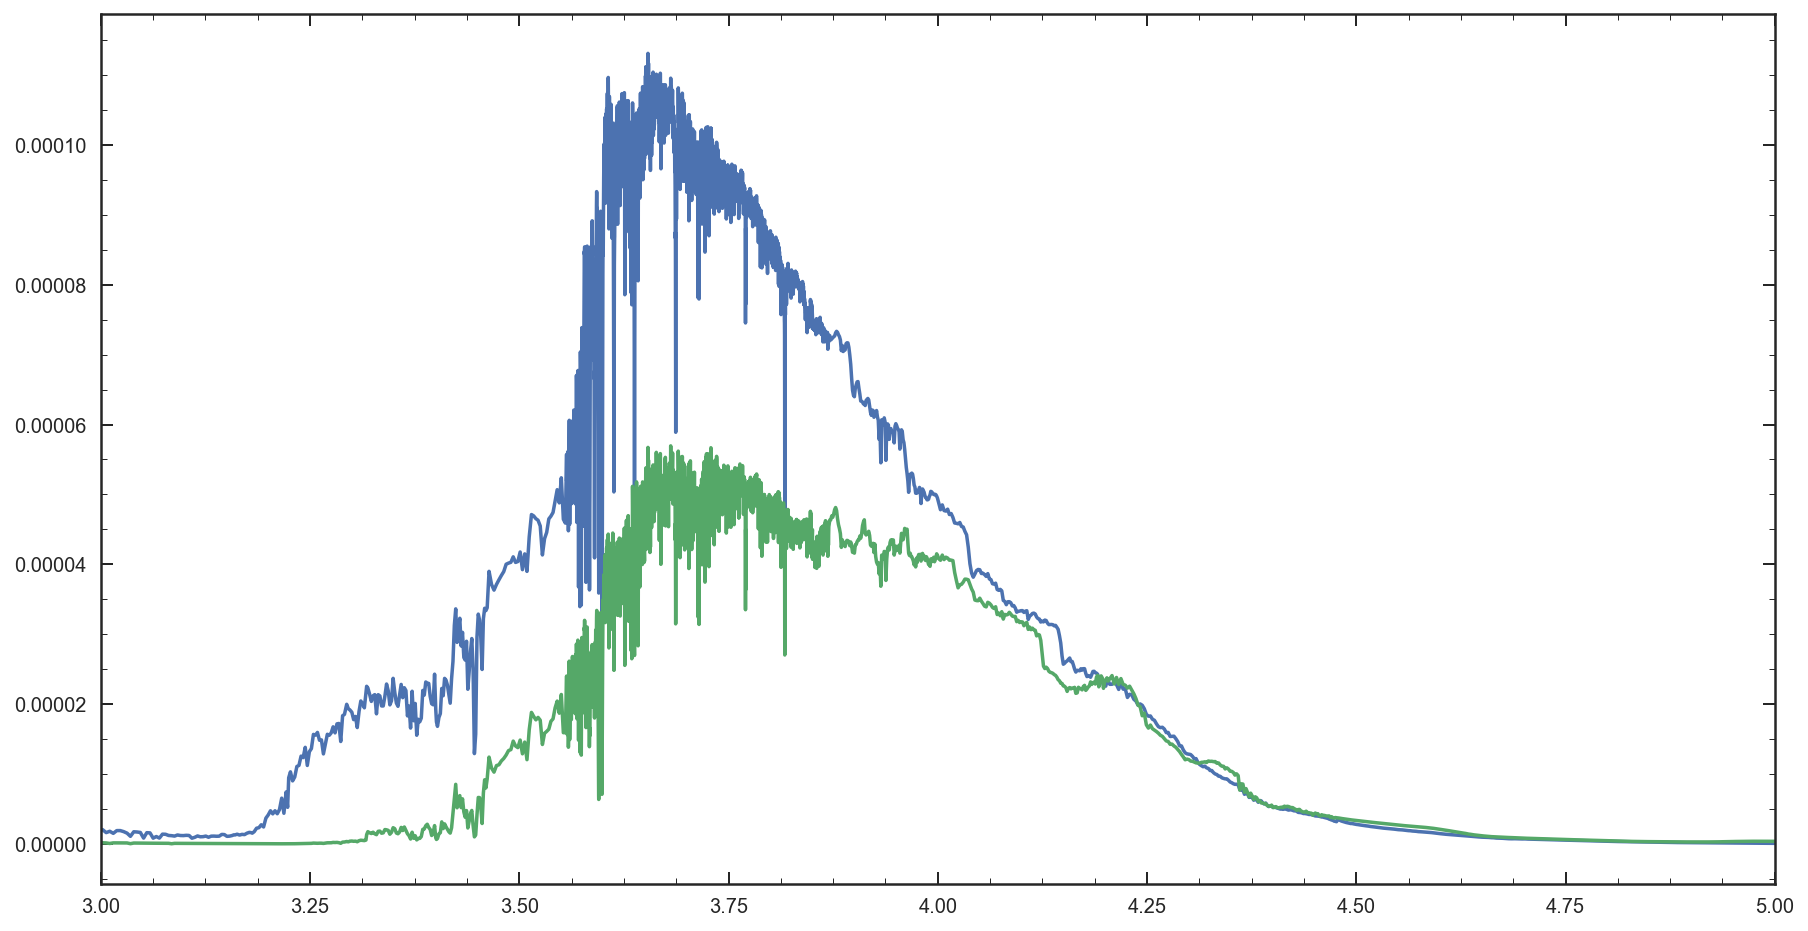

In [347]:
plt.figure(figsize=[15,8])
wv,fl = np.load('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m0.002_a2.3_dt8.0_spec.npy')
plt.plot(np.log10(wv),fl)
wv,fl = np.load('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m0.03_a2.3_dt8.0_spec.npy')
plt.plot(np.log10(wv),fl)             
plt.xlim(3,5)

In [ ]:
def Fit_all_sim(field, galaxy, g102_beam, g141_beam, specz, metal, age, tau, rshift, dust, 
                simZ, simt, simtau, simz, simd, name, gen_models = True, 
                age_conv= data_path + 'light_weight_scaling_3.npy', errterm = 0,
           outname = 'none'):
   
    if outname == 'none':
        outname = name
    ######## initialize spec
    
    sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(simZ/0.019), sfh = 4, tau = simtau)
    wave, flux = sp.get_spectrum(tage = simt, peraa = True)

    sim1 = Gen_sim(field, galaxy, specz, g102_beam, g141_beam,
                   wave, flux, 11, sp.stellar_mass, g102_lims=[8500,11300], 
                   tmp_err=True, phot_errterm = errterm, offset=True, offset_limit=0.5 )    
    if gen_models:
        Gen_mflgrid(sp, name, metal, age, tau, rshift)

    ## set some variables
    wv,fl = np.load(model_path + 'm0.019_a2.0_dt8.0_spec.npy')
    [Bmwv,Bmflx], [Rmwv,Rmflx] = sp.Sim_spec_mult(wv,fl)
    
    Stitch_resize_redden_fit2(sp.Pwv, sp.SPflx, sp.SPer, 'none', 'phot', name, sp.Pwv, 
                     metal, age, tau, rshift, outname, phot = True) 
    
    Stitch_resize_redden_fit2(sp.Bwv, sp.SBflx, sp.SBer, sp.Btrans, 'g102', name, Bmwv, 
                     metal, age, tau, rshift, outname)
    Stitch_resize_redden_fit2(sp.Rwv, sp.SRflx, sp.SRer, sp.Rtrans, 'g141', name, Rmwv, 
                     metal, age, tau, rshift, outname)

    P, PZ, Pt, Ptau, Pz, Pd = Analyze_full_fit(outname, metal, age, tau, rshift, 
                                               dust=dust,age_conv = age_conv)

    np.save(out_path + '{0}_tZ_sim_pos'.format(outname),P)
    np.save(out_path + '{0}_Z_sim_pos'.format(outname),[metal,PZ])
    np.save(out_path + '{0}_t_sim_pos'.format(outname),[age,Pt])
    np.save(out_path + '{0}_tau_sim_pos'.format(outname),[np.append(0, np.power(10, np.array(tau)[1:] - 9)),Ptau])
    np.save(out_path + '{0}_rs_sim_pos'.format(outname),[rshift,Pz])
    np.save(out_path + '{0}_d_sim_pos'.format(outname),[dust,Pd])

In [83]:
Z,PZ = np.load('../data/posteriors/sim_fit_GSD_41520_Z_sim_pos.npy')
t,Pt = np.load('../data/posteriors/sim_fit_GSD_41520_t_sim_pos.npy')
ult,Ptau = np.load('../data/posteriors/sim_fit_GSD_41520_tau_sim_pos.npy')
d,Pd = np.load('../data/posteriors/sim_fit_GSD_41520_d_sim_pos.npy')

Z,PZfs = np.load('../data/posteriors/sim_fit_GSD_41520_Z_sim_pos_fs.npy')
t,Ptfs = np.load('../data/posteriors/sim_fit_GSD_41520_t_sim_pos_fs.npy')
ult,Ptaufs = np.load('../data/posteriors/sim_fit_GSD_41520_tau_sim_pos_fs.npy')
d,Pdfs = np.load('../data/posteriors/sim_fit_GSD_41520_d_sim_pos_fs.npy')

# Z,BPZ = np.load('../data/posteriors/sim_fit_GSD_41520_Z_g102_pos.npy')
# t,BPt = np.load('../data/posteriors/sim_fit_GSD_41520_t_g102_pos.npy')
# ult,BPtau = np.load('../data/posteriors/sim_fit_GSD_41520_tau_g102_pos.npy')
# z,BPz = np.load('../data/posteriors/sim_fit_GSD_41520_rs_g102_pos.npy')
# d,BPd = np.load('../data/posteriors/sim_fit_GSD_41520_d_g102_pos.npy')

# Z,RPZ = np.load('../data/posteriors/sim_fit_GSD_41520_Z_g141_pos.npy')
# t,RPt = np.load('../data/posteriors/sim_fit_GSD_41520_t_g141_pos.npy')
# ult,RPtau = np.load('../data/posteriors/sim_fit_GSD_41520_tau_g141_pos.npy')
# z,RPz = np.load('../data/posteriors/sim_fit_GSD_41520_rs_g141_pos.npy')
# d,RPd = np.load('../data/posteriors/sim_fit_GSD_41520_d_g141_pos.npy')

# Z,PPZ = np.load('../data/posteriors/sim_fit_GSD_41520_Z_phot_pos.npy')
# t,PPt = np.load('../data/posteriors/sim_fit_GSD_41520_t_phot_pos.npy')
# ult,PPtau = np.load('../data/posteriors/sim_fit_GSD_41520_tau_phot_pos.npy')
# z,PPz = np.load('../data/posteriors/sim_fit_GSD_41520_rs_phot_pos.npy')
# d,PPd = np.load('../data/posteriors/sim_fit_GSD_41520_d_phot_pos.npy')

# Z,GPZ = np.load('../data/posteriors/sim_fit_GSD_41520_Z_grism_pos.npy')
# t,GPt = np.load('../data/posteriors/sim_fit_GSD_41520_t_grism_pos.npy')
# ult,GPtau = np.load('../data/posteriors/sim_fit_GSD_41520_tau_grism_pos.npy')
# z,GPz = np.load('../data/posteriors/sim_fit_GSD_41520_rs_grism_pos.npy')
# d,GPd = np.load('../data/posteriors/sim_fit_GSD_41520_d_grism_pos.npy')


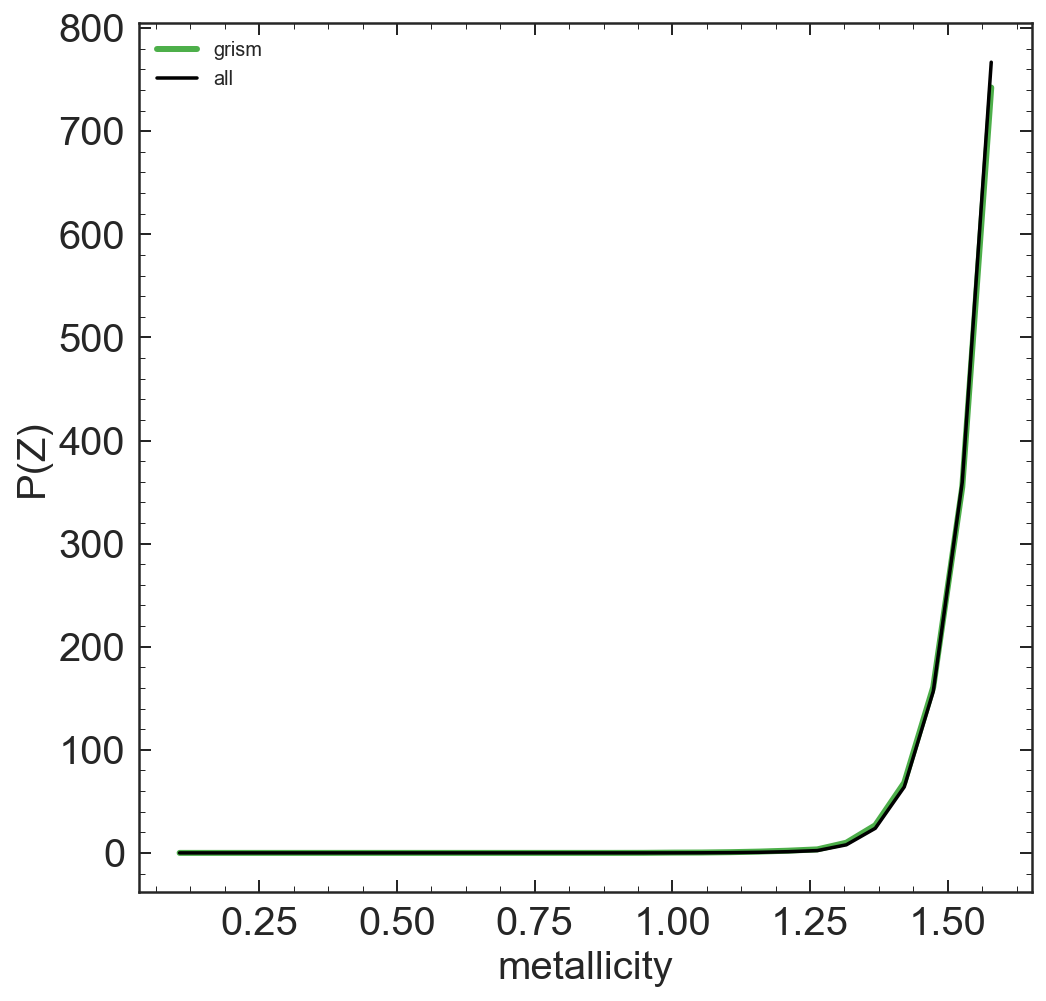

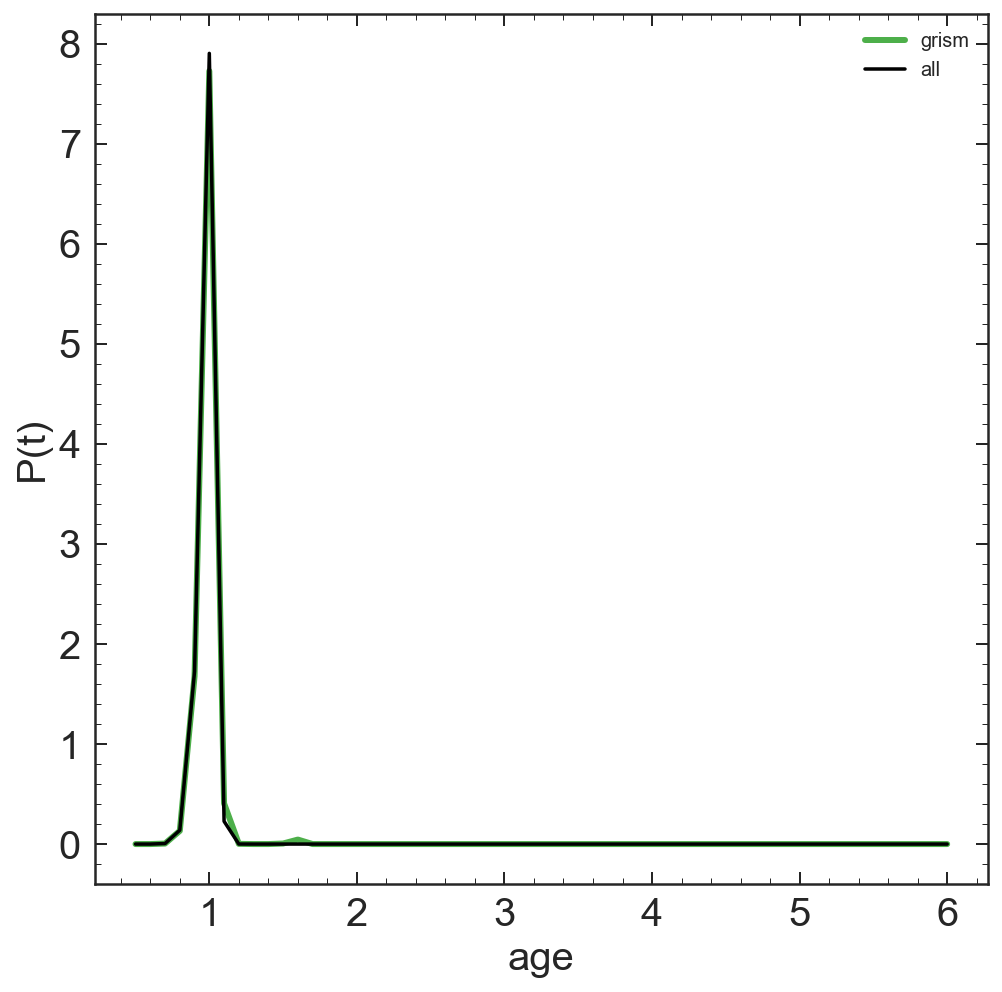

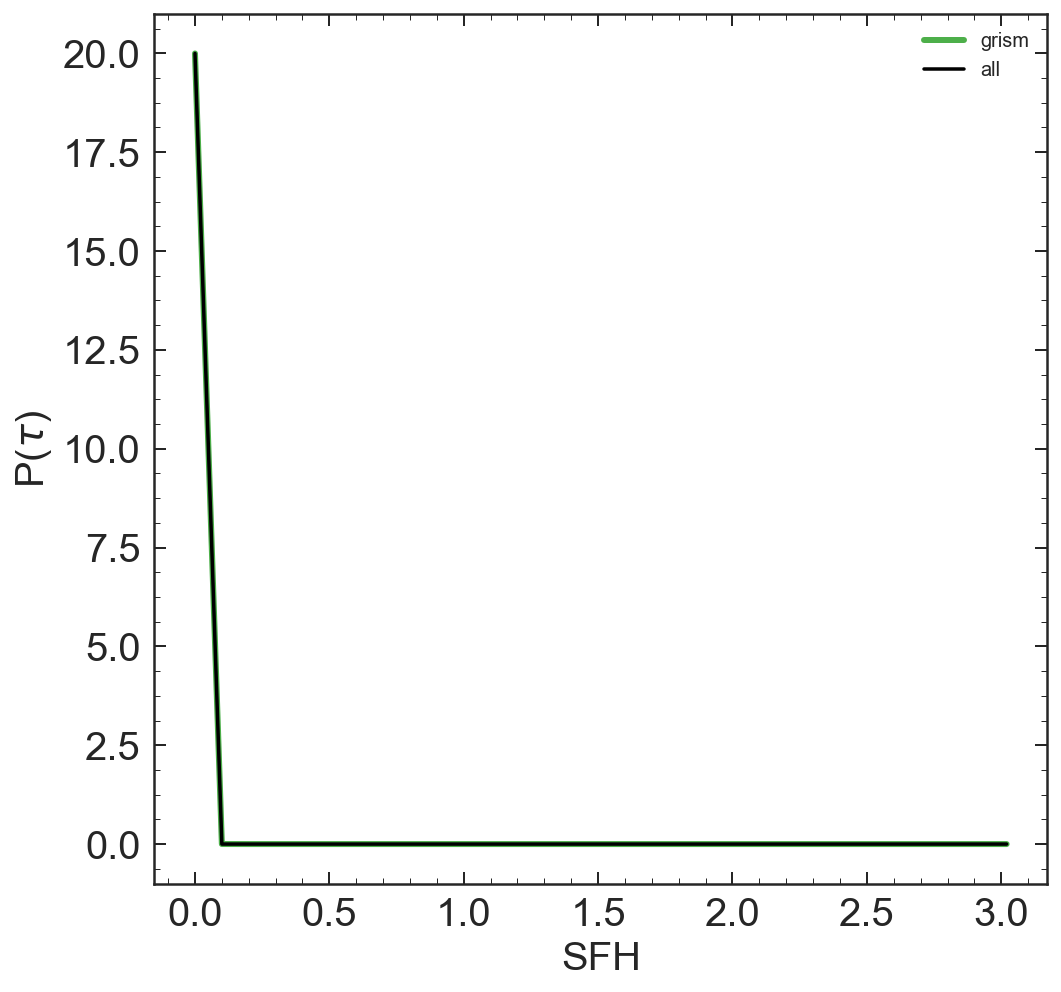

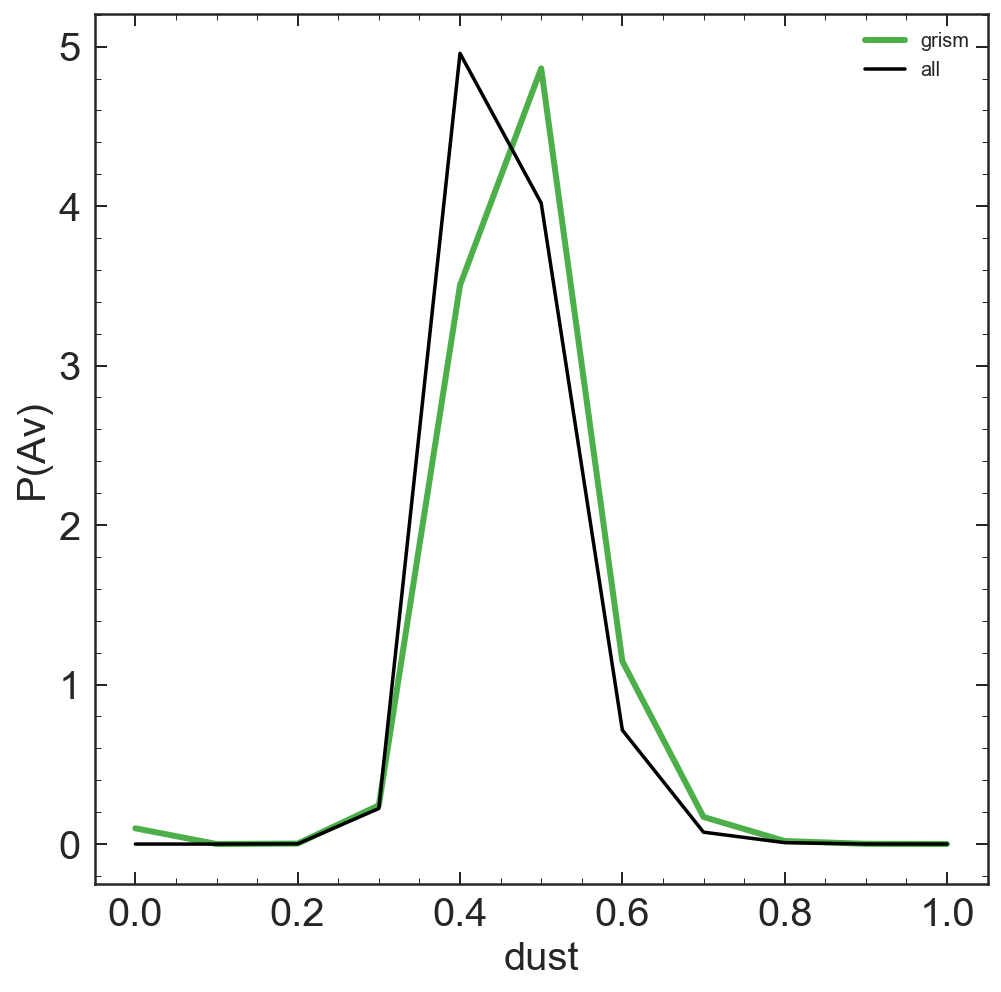

In [84]:
plt.figure(figsize=[8,8])
# plt.plot(Z/0.019 ,BPZ, linewidth = 3, color='#377eb8', label = 'g102')
# plt.plot(Z/0.019 ,RPZ, linewidth = 3, color='#e41a1c', label = 'g141')
# plt.plot(Z/0.019 ,PPZ, linewidth = 3, color='#984ea3', label = 'phot')
plt.plot(Z/0.019 ,PZfs, linewidth = 3, color='#4daf4a', label = 'grism')
plt.plot(Z/0.019 ,PZ, color='k', label = 'all')
plt.xlabel('metallicity', fontsize=20)
plt.ylabel('P(Z)', fontsize=20)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=20)

plt.figure(figsize=[8,8])
# plt.plot(t ,BPt, linewidth = 3, color='#377eb8', label = 'g102')
# plt.plot(t ,RPt, linewidth = 3, color='#e41a1c', label = 'g141')
# plt.plot(t ,PPt, linewidth = 3, color='#984ea3', label = 'phot')
plt.plot(t ,Ptfs, linewidth = 3, color='#4daf4a', label = 'grism')
plt.plot(t ,Pt, color='k', label = 'all')
plt.xlabel('age', fontsize=20)
plt.ylabel('P(t)', fontsize=20)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=20)

plt.figure(figsize=[8,8])
# plt.plot(ult ,BPtau, linewidth = 3, color='#377eb8', label = 'g102')
# plt.plot(ult ,RPtau, linewidth = 3, color='#e41a1c', label = 'g141')
# plt.plot(ult ,PPtau, linewidth = 3, color='#984ea3', label = 'phot')
plt.plot(ult ,Ptaufs, linewidth = 3, color='#4daf4a', label = 'grism')
plt.plot(ult ,Ptau, color='k', label = 'all')
plt.xlabel('SFH', fontsize=20)
plt.ylabel('P($\\tau$)', fontsize=20)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=20)

plt.figure(figsize=[8,8])
# plt.plot(d ,BPd, linewidth = 3, color='#377eb8', label = 'g102')
# plt.plot(d ,RPd, linewidth = 3, color='#e41a1c', label = 'g141')
# plt.plot(d ,PPd, linewidth = 3, color='#984ea3', label = 'phot')
plt.plot(d ,Pdfs, linewidth = 3, color='#4daf4a', label = 'grism')
plt.plot(d ,Pd, color='k', label = 'all')
plt.xlabel('dust', fontsize=20)
plt.ylabel('P(Av)', fontsize=20)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=20)

# def salmon dust law

calzetti: $A'(\lambda)=E(B−V)k'(\lambda)$

salmon: $A(\lambda,\delta) = E(B−V) k(\lambda)(\lambda/\lambda_V)^\delta$

calzetti: $10^{-0.4 k(\lambda)A_v/R_v}$

salmon: $10^{-0.4 k(\lambda)(\lambda/\lambda_V)^\delta A_v/R_v}$

$\delta = (0.62) log(E(B − V )) + 0.26$

In [70]:
def Calzetti_low(Av,lam):
    lam = lam * 1E-4
    Rv = 4.05
    k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
    cal = 10**(-0.4*k*Av/Rv)
    return cal

def Calzetti_hi(Av,lam):
    lam = lam * 1E-4
    Rv=4.05
    k = 2.659*(-1.857 +1.04/(lam)) + Rv
    cal = 10**(-0.4*k*Av/Rv)    
    
    return cal

def Calzetti(Av,lam):
    dust = Calzetti_low(Av,lam)
    dust2 = Calzetti_hi(Av,lam)
    
    for ii in range(len(dust)):
        if lam[ii] > 6300:
            dust[ii]=dust2[ii] 
    return dust

def C_k_low(lam):
    lam = lam * 1E-4
    Rv = 4.05
    return 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv 

def C_k_hi(lam):
    lam = lam * 1E-4
    Rv=4.05
    return 2.659*(-1.857 +1.04/(lam)) + Rv

def C_k(lam):
    dust = C_k_low(lam)
    dust2 = C_k_hi(lam)
    
    for ii in range(len(dust)):
        if lam[ii] > 6300:
            dust[ii]=dust2[ii] 
    return dust

def Salmon_low(Av,lam):
    lam = lam * 1E-4
    lamv = 5510 * 1E-4
    Rv=4.05
    delta = 0.62 * np.log10(Av/Rv) + 0.26
    k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
    cal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
    return cal

def Salmon_hi(Av,lam):
    lam = lam * 1E-4
    lamv = 5510 * 1E-4
    Rv=4.05
    delta = 0.62 * np.log10(Av/Rv) + 0.26
    k = 2.659*(-1.857 +1.04/(lam)) + Rv
    cal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)    
    
    return cal

def Salmon(Av,lam):
    dust = Salmon_low(Av,lam)
    dust2 = Salmon_hi(Av,lam)
    
    for ii in range(len(dust)):
        if lam[ii] > 6300:
            dust[ii]=dust2[ii] 
    if Av == 0:
        dust = np.ones(len(dust))
    return dust

def S_k_low(lam, delta):
    lam = lam * 1E-4
    lamv = 5510 * 1E-4
    Rv=4.05
    k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
    return k*(lam / lamv)**(delta)

def S_k_hi(lam, delta):
    lam = lam * 1E-4
    lamv = 5510 * 1E-4
    Rv=4.05
    k = 2.659*(-1.857 +1.04/(lam)) + Rv    
    return k*(lam / lamv)**(delta)

def S_k(lam,delta):
    dust = S_k_low(lam,delta)
    dust2 = S_k_hi(lam,delta)
    
    for ii in range(len(dust)):
        if lam[ii] > 6300:
            dust[ii]=dust2[ii] 
    
    return dust

In [41]:
cal = Calzetti(1,wave)
sal = Salmon(1,wave)

(2, 6)

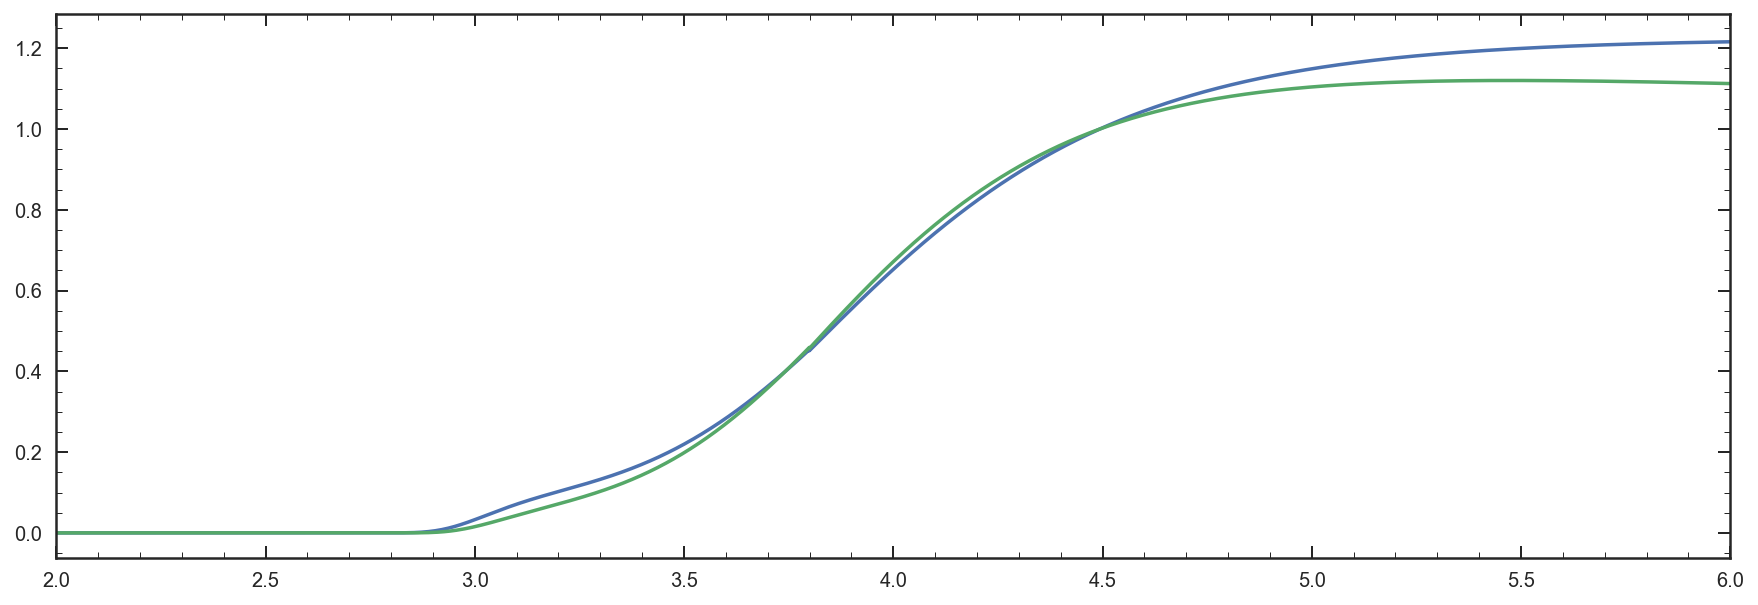

In [42]:
plt.figure(figsize=[15,5])
plt.plot(np.log10(wave),cal)
plt.plot(np.log10(wave),sal)
plt.xlim(2,6)

In [73]:
7900 / 3.5, 16000 / 1.9

(2257.1428571428573, 8421.052631578948)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in multiply
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in multiply


(3.3521825181113627, 3.9253120914996495)

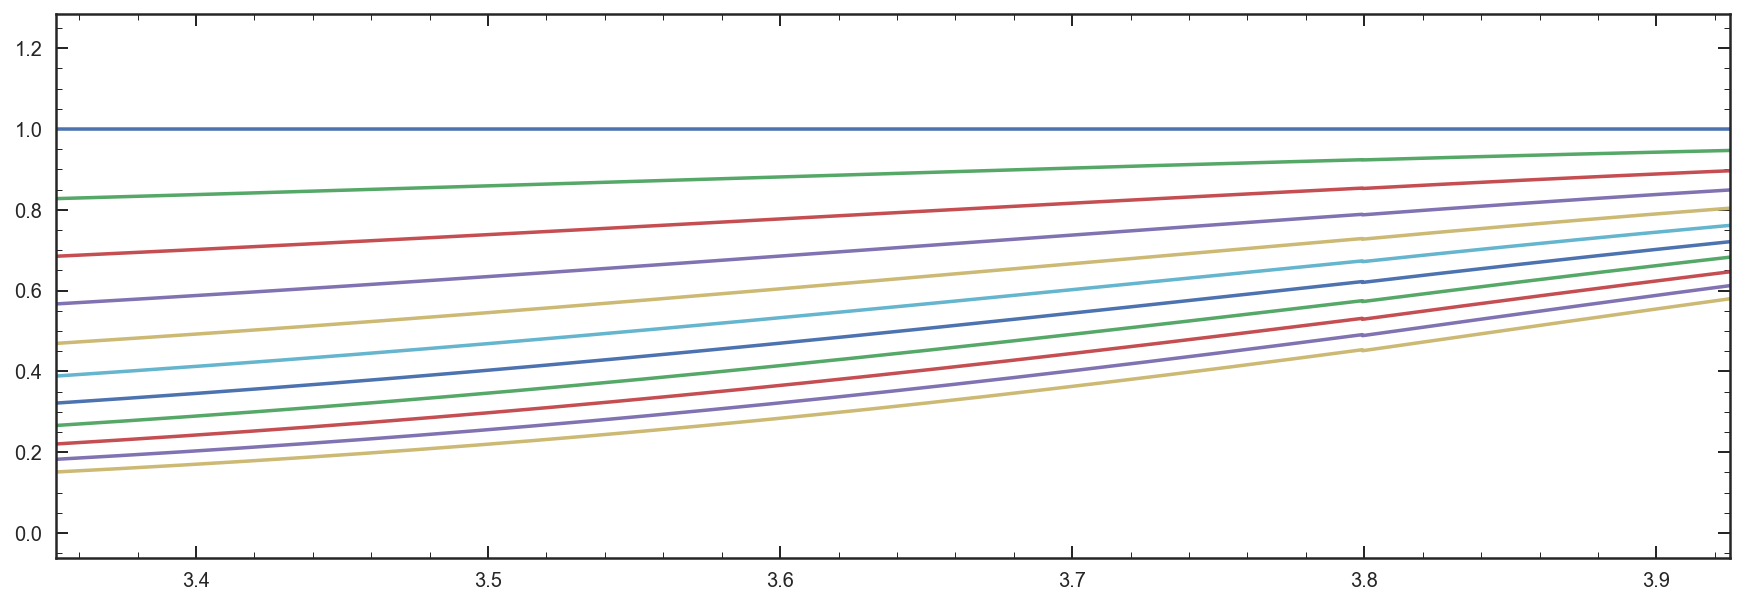

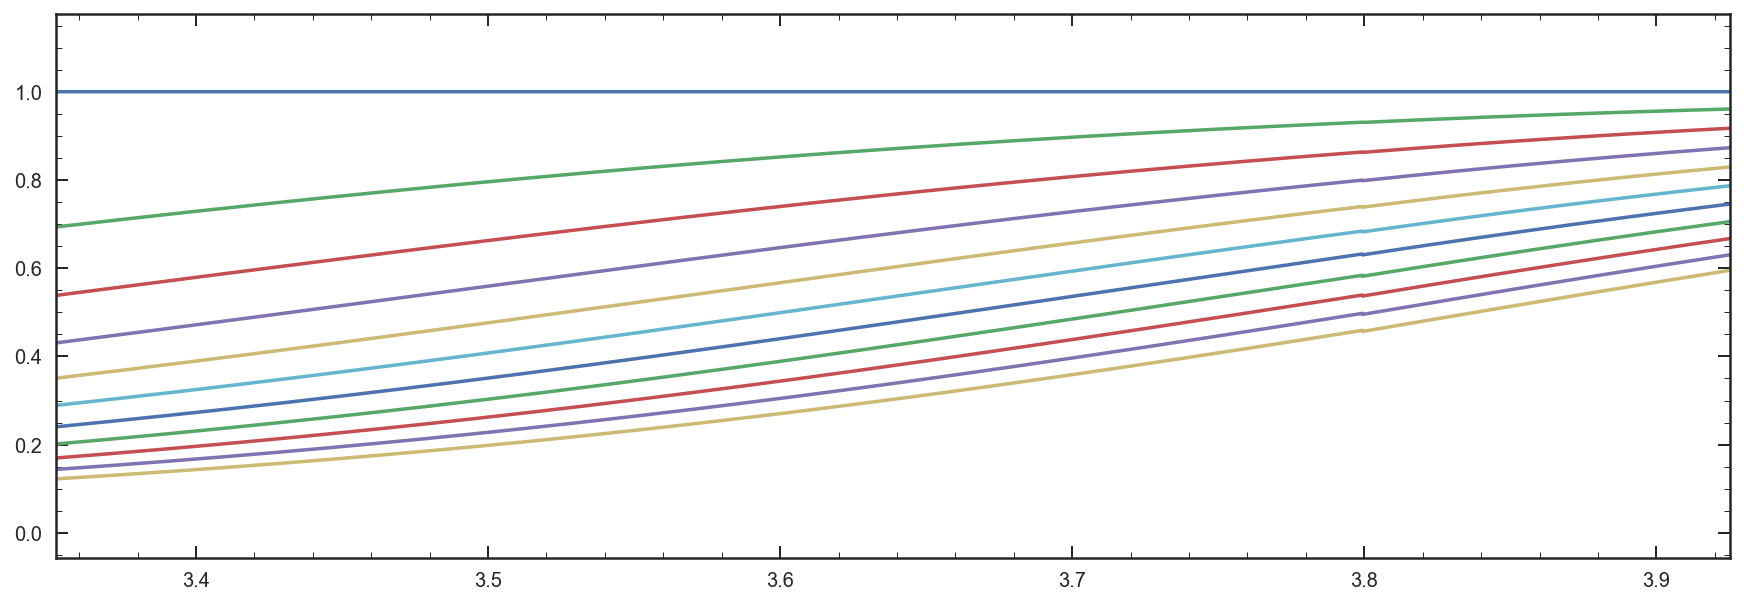

In [75]:
plt.figure(figsize=[15,5])

for i in np.arange(0,1.1,0.1):
    plt.plot(np.log10(wave), Calzetti(i,wave))
plt.xlim(np.log10(2250),np.log10(8420))

plt.figure(figsize=[15,5])

for i in np.arange(0,1.1,0.1):
    plt.plot(np.log10(wave), Salmon(i,wave))
plt.xlim(np.log10(2250),np.log10(8420))


In [69]:
Salmon(0,wave)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in multiply
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in multiply


array([nan, nan, nan, ...,  1.,  1.,  1.])

In [65]:
Av = np.arange(0,3,0.1)
Rv=4.05
delta = 0.62 * np.log10(Av/Rv) + 0.26
ebv = Av / Rv

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


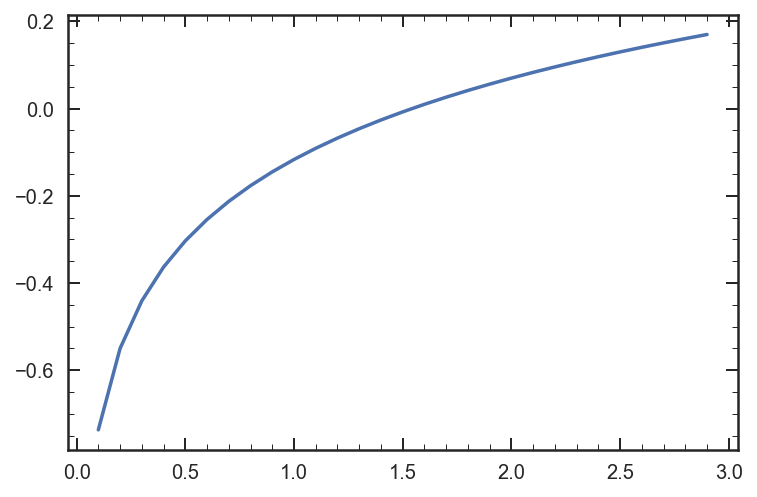

In [67]:
plt.plot(Av, delta)
# plt.xlim(0,0.7)
# plt.ylim(-0.65,0.55)

In [50]:
ck = C_k(wave)
sk = S_k(wave,0)

(-1, 20)

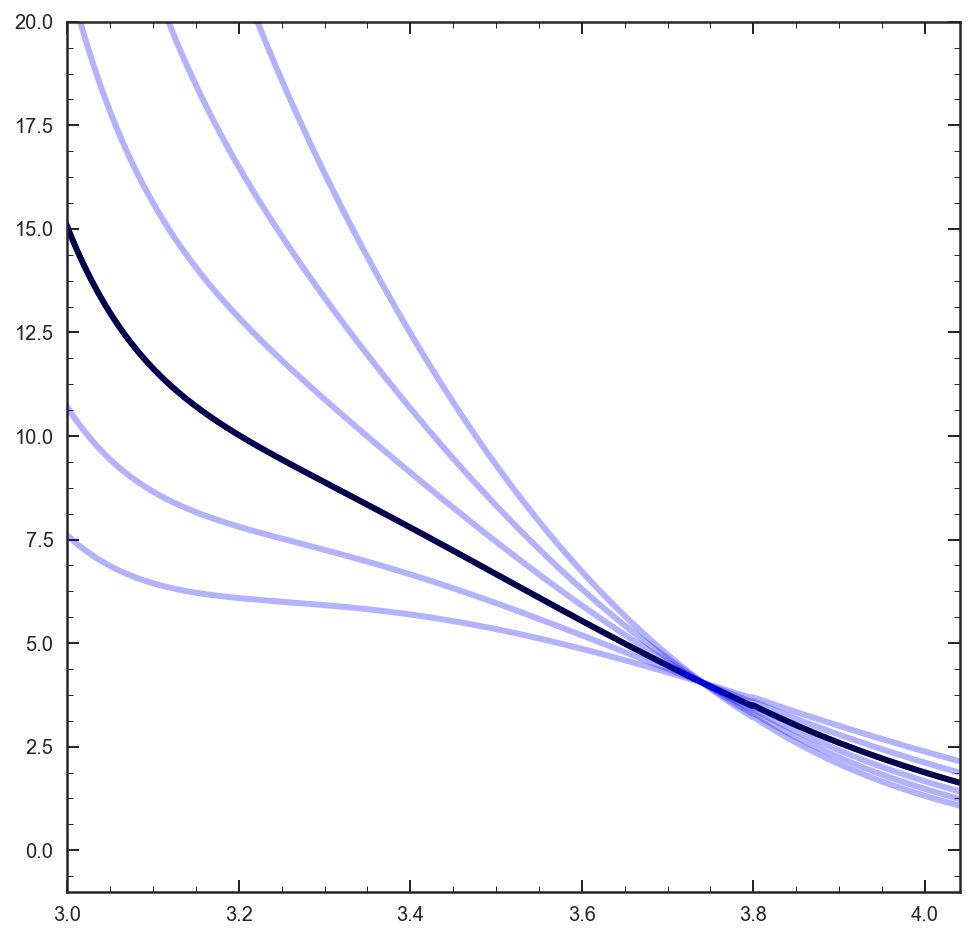

In [63]:
plt.figure(figsize=[8,8])
plt.plot(np.log10(wave),ck,'k', linewidth=3)

for i in np.arange(-0.6,0.5,0.2):
    sk = S_k(wave,i)
    plt.plot(np.log10(wave),sk,'b', linewidth=3, alpha=0.3)
plt.xlim(np.log10(1000),np.log10(11000))
plt.ylim(-1,20)